# Matlab Model Sync

## Force and Moment Calculation (Validated with New `get_forces_torques`)

Systematically testing each aspect of the Python/Matlab UAV models to ensure they match as close as possible

In [213]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np
import pandas as pd
from copy import deepcopy

from multirotor.coords import body_to_inertial, direction_cosine_matrix, inertial_to_body, rotating_frame_derivative
from multirotor.simulation import Multirotor
from multirotor.helpers import DataLog
from multirotor.trajectories import Trajectory
from multirotor.vehicle import BatteryParams, MotorParams, PropellerParams, VehicleParams, SimulationParams

In [214]:
scenarios = ['nominal']
modes = ['python', 'matlab']

scenario = scenarios[0]
mode = modes[1]

## Simulating Forces and Moments

In [215]:
# importing from matlab
nominal_states = pd.read_csv(f'../data/{scenario}_states.csv')
motor_speeds = pd.read_csv(f'../data/{scenario}_speeds.csv')

nominal_f = pd.read_csv(f'../data/{scenario}_f.csv')
nominal_t = pd.read_csv(f'../data/{scenario}_m.csv')

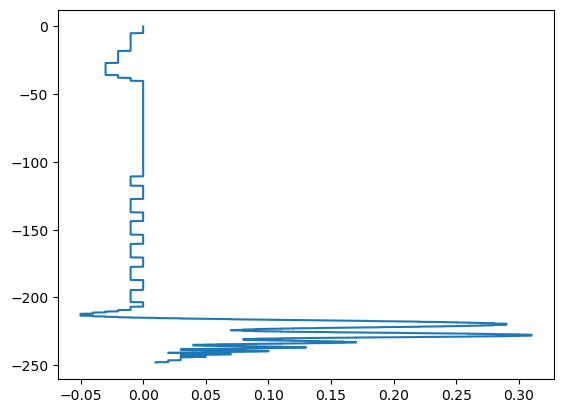

In [216]:
state_array = np.array(nominal_states)
plt.plot(state_array[:,0], state_array[:,1])

In [217]:
BP = BatteryParams(max_voltage=22.2)
MP = MotorParams(
    moment_of_inertia=5e-5,
    resistance=0.27,
    # resistance=0.081,
    k_emf=0.0265,
    k_motor=0.0932,
    speed_voltage_scaling=0.0347,
    max_current=38.
)
PP = PropellerParams(
    moment_of_inertia=1.86e-6,
    use_thrust_constant=True,
    k_thrust=9.8419e-05, # 18-inch propeller
    # k_thrust=5.28847e-05, # 15 inch propeller
    k_drag=1.8503e-06, # 18-inch propeller
    # k_drag=1.34545e-06, # 15-inch propeller
    motor=MP
    # motor=None
)
VP = VehicleParams(
    propellers=[deepcopy(PP) for _ in range(8)],
    battery=BP,
    # angles in 45 deg increments, rotated to align with
    # model setup in gazebo sim (not part of this repo)
    angles=np.linspace(0, -2*np.pi, num=8, endpoint=False) + 0.375 * np.pi, # np.pi / 2
    distances=np.ones(8) * 0.635,
    clockwise=[-1,1,-1,1,-1,1,-1,1],
    mass=10.66,
    inertia_matrix=np.asarray([
        [0.2506, 0, 0],
        [0, 0.2506, 0.],
        [0, 0, 0.4538]
    ])
)
SP = SimulationParams(dt=0.01, g=9.81, dtype=np.float32)

m = Multirotor(VP, SP)

In [218]:
m.battery

In [219]:
def torque(
    position_vector: np.ndarray, force: np.ndarray,
    moment_of_inertia: float, prop_angular_acceleration: float,
    drag_coefficient: float, prop_angular_velocity: float,
    clockwise: int
) -> np.ndarray:
    """
    Calculates the torque acting on the three body axes (roll, pitch, yaw), due 
    to a single propeller.

    Parameters
    ----------
    position_vector : np.ndarray
        Position vector of force, relative to center of mass. If multiple vectors,
        should be in shape 3 x n_vectors.
    force : np.ndarray
        Force vector acting at that position (nominally thrust). If multiple vectors,
        should be in shape 3 x n_vectors.
    moment_of_inertia : float
        Moment of inertia of the body.
    prop_angular_acceleration : float
        Angular acceleration experienced by propeller.
    drag_coefficient : float
        The drag coefficient of propeller.
    prop_angular_velocity : float
        Propeller speed (rad/s)
    clockwise : int
        Whether propeller is spinning clockwise or counter clockwise.

    Returns
    -------
    np.ndarray
        The torque due to the propeller acting on the center of mass.
    """
    # TODO: See here
    # https://andrew.gibiansky.com/downloads/pdf/Quadcopter%20Dynamics,%20Simulation,%20and%20Control.pdf
    # Total moments in the body frame
    # yaw moments
    # tau = I . d omega/dt
    tau_rot = (
        # angular acceleration of propellers is assumed to be negligible
        # clockwise * moment_of_inertia * prop_angular_acceleration + 
        clockwise * drag_coefficient * prop_angular_velocity**2
    )
    # tau = r x F
    # numba does not support axis arguments for cross(), so taking transpose and
    # then undoing it for result:
    tau = np.cross(position_vector.T, force.T).T
    tau[2] = tau[2] + tau_rot
    return tau

def get_forces_torques(speeds: np.ndarray, state: np.ndarray):
        """
        Calculate the forces and torques acting on the vehicle's center of gravity
        given its current state and speed of propellers.

        Parameters
        ----------
        speeds : np.ndarray
            Propeller speeds (rad/s)
        state : np.ndarray
            State of the vehicle (position, velocity, orientation, angular rate)

        Returns
        -------
        Tuple[np.ndarray, np.ndarray]
            The forces and torques acting on the body.
        """
        linear_vel_body = state[:3]
        angular_vel_body = state[3:6]
        airstream_velocity_inertial = rotating_frame_derivative(
            VP.propeller_vectors,
            linear_vel_body,
            angular_vel_body)

        thrust_vec = np.zeros((3, len(VP.propellers)), dtype=np.float32)
        torque_vec = np.zeros_like(thrust_vec)

        for i, (speed, prop, clockwise) in enumerate(zip(
                speeds,
                m.propellers,
                VP.clockwise)
        ):
            last_speed = prop.speed
            speed = prop.apply_speed(speed, max_voltage=m.battery.voltage)
            angular_acc = (speed - last_speed) / SP.dt
            thrust_vec[2, i] = prop.thrust(
                speed, airstream_velocity_inertial[:, i]
            )
            torque_vec[:, i] = torque(
                VP.propeller_vectors[:,i], thrust_vec[:,i],
                prop.params.moment_of_inertia, angular_acc,
                prop.params.k_drag, speed,
                clockwise
            )
        forces = thrust_vec.sum(axis=1)
        torques = torque_vec.sum(axis=1)
        return forces, torques

def get_forces_torques_matlab(speeds: np.ndarray, state: np.ndarray):
        """
        Calculate the forces and torques acting on the vehicle's center of gravity
        given its current state and speed of propellers.

        Parameters
        ----------
        speeds : np.ndarray
            Propeller speeds (rad/s)
        state : np.ndarray
            State of the vehicle (position, velocity, orientation, angular rate)

        Returns
        -------
        Tuple[np.ndarray, np.ndarray]
            The forces and torques acting on the body.
        """
        l = 0.635
        
        b=9.8419e-05
        T = b*(speeds**2)

        T_total=np.sum(T)

        Ftot_b=[0, 0, T_total]
        Fx=Ftot_b[0]
        Fy=Ftot_b[1]
        Fz=Ftot_b[2]

        d=1.8503e-06; 
        M = d*(speeds**2)
        
        angsm=np.cos(np.pi/8) 
        anglg=np.cos(3*np.pi/8)

        Mx=l*(-T[0]*anglg -T[1]*angsm +T[2]*angsm +T[3]*anglg +T[4]*anglg+T[5]*angsm -T[6]*angsm -T[7]*anglg)

        My=l*(-T[0]*angsm -T[1]*anglg -T[2]*anglg -T[3]*angsm +T[4]*angsm+T[5]*anglg +T[6]*anglg +T[7]*angsm)

        Mz= M[0] -M[1] +M[2] -M[3] +M[4] -M[5] +M[6] -M[7]
        return np.array([Fx, Fy, Fz], dtype=np.float32).squeeze(), np.array([Mx, My, Mz], dtype=np.float32)

def simulate_ft_calc(speeds, states):
    speeds = 0.10472 * speeds
    log = []

    for w, s in zip(speeds, states):
        dcm = direction_cosine_matrix(s[6], s[7], s[8])
        dcm = dcm.astype(np.float32)
        s = np.array(s, dtype=np.float32)
        if mode == 'python':
            # s[3:6] = inertial_to_body(s[3:6], dcm)
            f, t = get_forces_torques(np.array(w), np.array(s))
        elif mode == 'matlab':
            f, t = get_forces_torques_matlab(np.array(w), np.array(s))
             

        log.append([*f, *t])

    return np.array(log)

In [220]:
log = simulate_ft_calc(np.array(motor_speeds), np.array(nominal_states))


In [221]:
log.shape

(2581, 6)

Text(0.5, 1.0, 'fx')

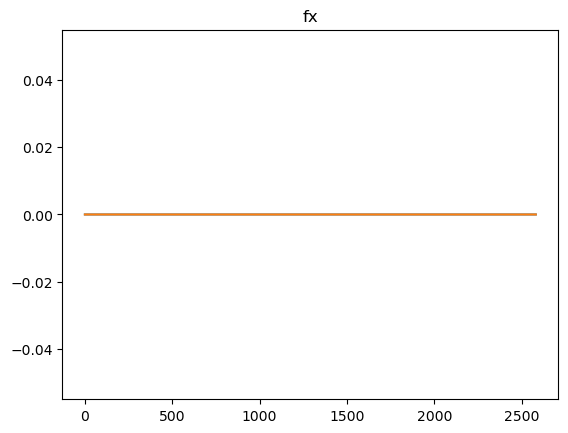

In [222]:
plt.plot(log[:,0])
plt.plot(np.array(nominal_f)[:,3])
plt.title("fx")

Text(0.5, 1.0, 'fy')

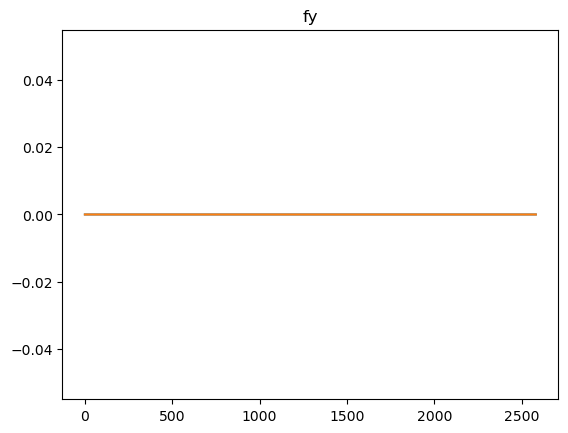

In [223]:
plt.plot(log[:,1])
plt.plot(np.array(nominal_f)[:,4])
plt.title("fy")

Text(0.5, 1.0, 'fz')

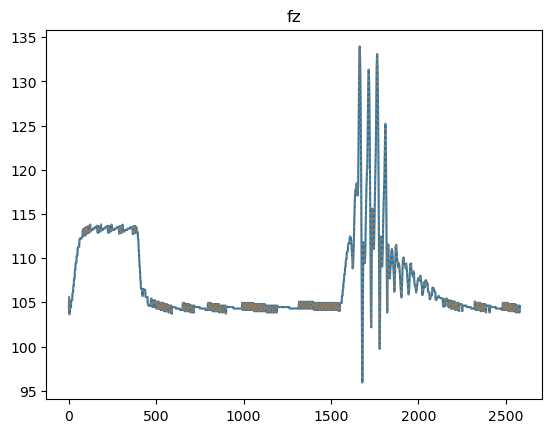

In [224]:
plt.plot(log[:,2])
plt.plot(np.array(nominal_f)[:,5], alpha=0.5, linestyle=':')
plt.title("fz")

Text(0.5, 1.0, 't1')

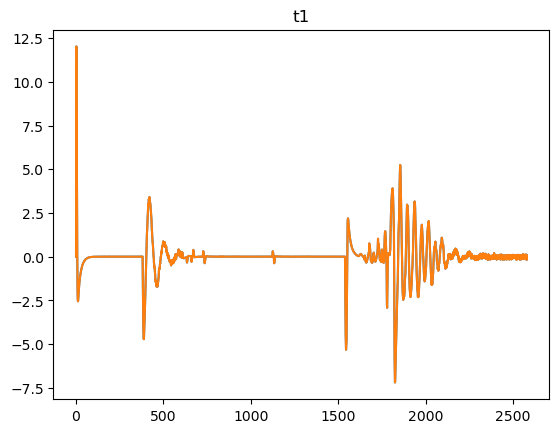

In [225]:
plt.plot(log[:,3])
plt.plot(np.array(nominal_t)[:,0])
plt.title("t1")

Text(0.5, 1.0, 't2')

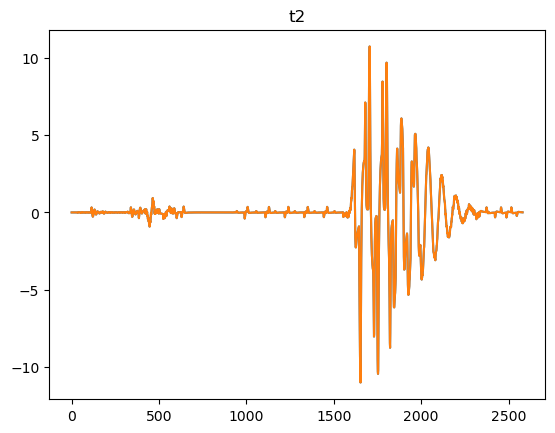

In [226]:
plt.plot(log[:,4])
plt.plot(np.array(nominal_t)[:,1])
plt.title("t2")

Text(0.5, 1.0, 't3')

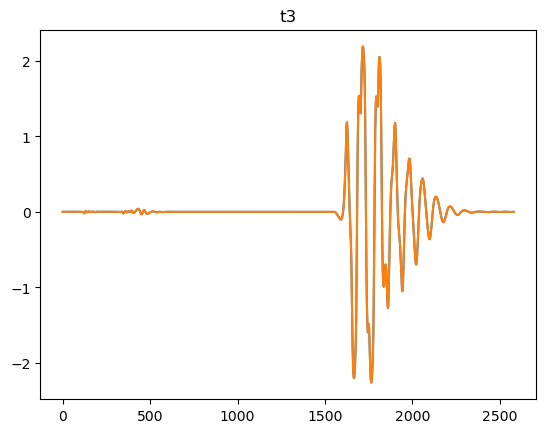

In [227]:
plt.plot(log[:,5])
plt.plot(np.array(nominal_t)[:,2])
plt.title("t3")